In [1]:
using Pkg

# Pkg.add(url="https://github.com/mppmu/BoostFractor.jl.git")
# Pkg.add(url="https://github.com/bergermann/Dragoon.jl.git")
Pkg.update()

    Updating registry at `C:\Users\domin\.julia\registries\General`
┌ Info: The General registry is installed via git. Consider reinstalling it via
│ the newer faster direct from tarball format by running:
│   pkg> registry rm General; registry add General
│ 
└ @ Pkg.Registry C:\Users\domin\.julia\juliaup\julia-1.11.3+0.x64.w64.mingw32\share\julia\stdlib\v1.11\Pkg\src\Registry\Registry.jl:478
    Updating git-repo `https://github.com/JuliaRegistries/General.git`
    Updating git-repo `https://github.com/mppmu/BoostFractor.jl.git`
    Updating git-repo `https://github.com/bergermann/Dragoon.jl.git`
   Installed GR_jll ─────────────────────── v0.73.17+0
   Installed Libmount_jll ───────────────── v2.41.1+0
   Installed x265_jll ───────────────────── v4.1.0+0
   Installed JpegTurbo_jll ──────────────── v3.1.3+0
   Installed libfdk_aac_jll ─────────────── v2.0.4+0
   Installed LERC_jll ───────────────────── v4.0.1+0
   Installed AxisArrays ─────────────────── v0.4.8
   Installed TiffImages

In [ ]:
using Dragoon
using Plots
# using Dates
include()

In [2]:
f0 = 22e9; ndisk=20; eps = 24.0; tand = 5e-6
fwidths = reverse(collect(range(400e6,50e6,100)))
# fwidths = [100e6]

d0 = ones(ndisk)*findpeak1d(f0,ndisk)
p0 = dist2pos(d0)

freqsplot = genFreqs(f0,fwidths[end]*1.1; n=1000) # plot with these frequencies

booster = AnalyticalBooster(p0; ϵ=eps,tand=tand,R=0.1)  # physical properties of the booster

AnalyticalBooster([0.007219271926312677, 0.015438543852625355, 0.02365781577893803, 0.03187708770525071, 0.04009635963156338, 0.04831563155787606, 0.05653490348418874, 0.06475417541050142, 0.0729734473368141, 0.08119271926312677, 0.08941199118943945, 0.09763126311575213, 0.1058505350420648, 0.11406980696837749, 0.12228907889469016, 0.13050835082100284, 0.13872762274731554, 0.1469468946736282, 0.15516616659994087, 0.1633854385262535], 20, 24.0, 5.0e-6, 0.001, 0.1, 0.0001, 2, Dates.DateTime("0000-01-01T00:00:00"), Dates.DateTime("0000-01-01T00:00:00"), 0.0, 0.0, 0.0)

In [18]:
pwd()


"c:\\Users\\domin\\OneDrive\\Desktop\\Julia Files\\Dragoon.jl\\examples\\anton stuff"

TRY EQUIDIST WITH HALF SPACING IN FRONT OF MIRROR

In [4]:
function findpeak1d_h(frequency::Real,ndisk::Int;
        eps::Real=24.,tand::Real=0.,thickness::Real=1e-3,
        granularity::Int=1000,deviation::Real=0.1,scale::Real=1.)

    λ = 299792458.0/frequency
    B = zeros(granularity)
    D = range(1-deviation; stop=1+deviation,length=granularity)*scale*λ/2

    for i in eachindex(D)
        d = [D[i]/2; ones(ndisk-1)*D[i]]
        B[i] = boost1d(Dist,d,[frequency];
            eps=eps,tand=tand,thickness=thickness)[1]
    end

    return D[argmax(B)]
end

findpeak1d_h (generic function with 1 method)

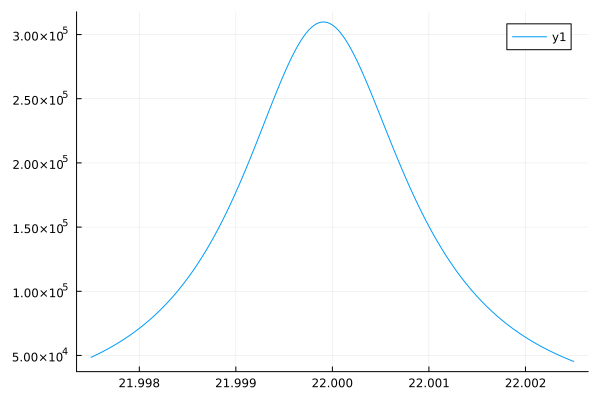

In [16]:
freqsplot = genFreqs(f0,5e6; n=5000)

d0 = findpeak1d_h(f0,ndisk; granularity=10_000,deviation=0.5)
p0 = dist2pos([d0/2; d0*ones(ndisk-1)])
move(booster,p0)

p = plot(freqsplot/1e9,getBoost1d(booster,freqsplot))

In [17]:
showFields(p0, f0; eps=eps, tand=tand)

UndefVarError: UndefVarError: `showFields` not defined in `Main`
Suggestion: check for spelling errors or missing imports.

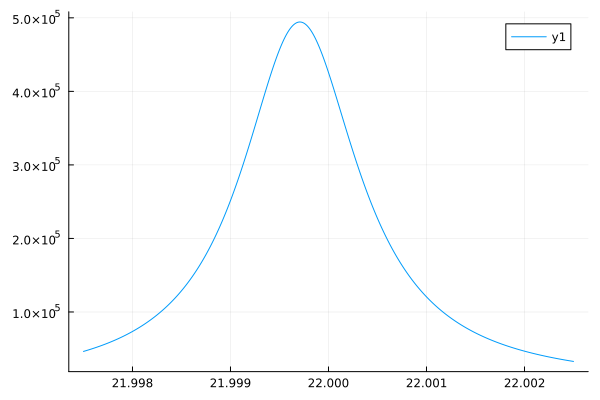

In [15]:
freqsplot = genFreqs(f0,5e6; n=5000)

d = 0.007219271926312677
d1 = d*ones(9)*(1-0e-3)
dm = d*(1-10e-3)
ds = d*(1-10e-3)

move(booster,dist2pos(d*ones(20)))
# p = plot(freqsplot/1e9,log.(10,getBoost1d(booster,freqsplot)))
p = plot(freqsplot/1e9,getBoost1d(booster,freqsplot))
# for i in 10:10:20
#     d2 = d*ones(9)*(1+i*1e-3)
#     D = [dm; d1; ds; d2]
#     move(booster,dist2pos(D))
#     plot!(p,freqsplot/1e9,log.(10,getBoost1d(booster,freqsplot)))
# end
# p

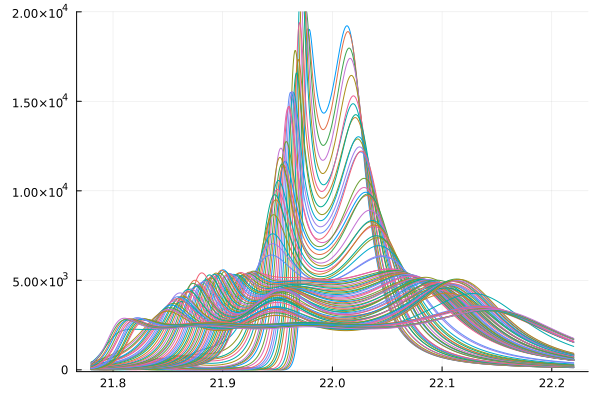

In [53]:
booster = AnalyticalBooster(p0; ϵ=eps,tand=tand,R=0.1)

H = Vector{Dragoon.State}[]
T = Vector{Dragoon.NMTrace}[]

p = plot(; ylims=[-0.1,20]*1e3,legend=false)
isc = 1e-4
for fwidth in fwidths
    freqs = genFreqs(f0,fwidth; n=100) # optimize on these frequencies
    hist = initHist(booster,10000,freqs,ObjAnalytical); # stores measurements

    trace = nelderMead(booster,hist,freqs,
                    1.,1+2/booster.ndisk,0.75-1/2booster.ndisk,1-1/booster.ndisk,1e-12,1e-12,
                    ObjAnalytical,
                    InitSimplexCoord(isc),
                    DefaultSimplexSampler,
                    UnstuckDont;
                    maxiter=Int(5e3),
                    showtrace=false,
                    showevery=100,
                    unstuckisiter=true);

    push!(H,hist)
    push!(T,trace)

    isc *= 0
    isc += 1e-7

    plot!(p,freqsplot/1e9,getBoost1d(booster,freqsplot))
end
p

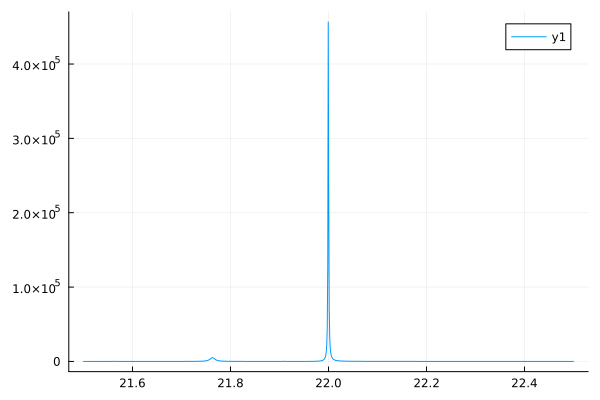

In [29]:
plot(freqsplot/1e9,getBoost1d(booster,freqsplot))

find configs with distinct boost lines, no overlap ideally